# Localized Translations A/B Testing Case Study
Brian Amadio

# 1. Investigate if the test is actually negative

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
test_df = pd.read_csv('Translation_Test__281_29/test_table.csv')
user_df = pd.read_csv('Translation_Test__281_29/user_table.csv')
df = pd.merge(test_df,user_df,on='user_id')

In [2]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


### Basic cleaning
Check for null values

In [3]:
df.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser                  0
conversion               0
test                     0
sex                      0
age                      0
country                  0
dtype: int64

## t-test
Test the null hypothesis that the means of the two samples are equal

In [4]:
from scipy.stats import ttest_ind
print(df.groupby('test')['conversion'].mean())

test
0    0.055156
1    0.043411
Name: conversion, dtype: float64


In [5]:
np.std(df[df['test']==0].conversion),np.std(df[df['test']==1].conversion)

(0.22828367168218983, 0.20378084483070583)

In [6]:
ttest_ind(df[df['test']==1].conversion,df[df['test']==0].conversion,equal_var=False)

Ttest_indResult(statistic=-18.291393187719883, pvalue=1.0312099061277833e-74)

The t-test suggests a highly significant result, but let's dig a little deeper

## Checking sample randomization with chi-square test
The simplest thing we could do is check if the two group sizes are compatible with users being randomly assigned with probability 50%. If this is the case, we expect the group sizes to be distributed according to the binomial distribution with p = .5

For large N, we can approximate the binomial distribution as normal, and use a simple chi-square test

In [7]:
df['conversion'].count()/2

226433.5

In [8]:
df.groupby('test')['conversion'].count()

test
0    237093
1    215774
Name: conversion, dtype: int64

In [9]:
from scipy.stats import chisquare
chisquare(f_obs=df.groupby('test')['conversion'].count())

Power_divergenceResult(statistic=1003.6053874537116, pvalue=2.9551941481608504e-220)

Conclusion: too many users are being assigned to the control group

## Exploring the distributions
Before doing any more statistical tests, it's worthwhile to just plot the distributions of various features to see if anything obvious stands out

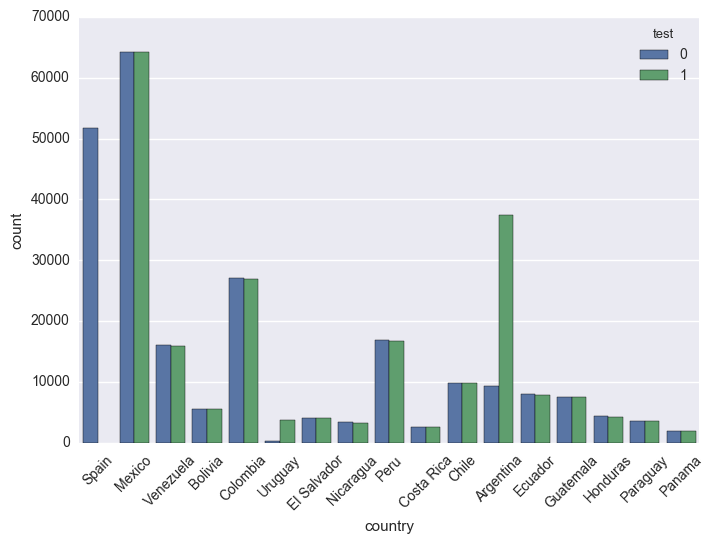

In [10]:
import seaborn as sns
country_plot=sns.countplot(x='country',hue='test',data=df)
for label in country_plot.get_xticklabels():
    label.set_rotation(45)

Obvious mistakes: Including users from Spain the experiment, over-assigning users from Uruguay and Argentina to the test group

## Mean per-country conversion rate

In [11]:
df.groupby('country')['conversion'].mean().mean()

0.047591540279439085

In [12]:
df.groupby('country')['conversion'].mean()

country
Argentina      0.013994
Bolivia        0.048634
Chile          0.049704
Colombia       0.051332
Costa Rica     0.053494
Ecuador        0.049072
El Salvador    0.050765
Guatemala      0.049653
Honduras       0.049253
Mexico         0.050341
Nicaragua      0.053399
Panama         0.048089
Paraguay       0.048863
Peru           0.050258
Spain          0.079719
Uruguay        0.012821
Venezuela      0.049666
Name: conversion, dtype: float64

Argentina and Uruguay stand out as having much lower than average conversion rates, while Spain stands out as having a much higher than average conversion rate

## Chi-squared test for Uruguay and Argentina
Testing the hypothesis that users were assigned to test or control group with probability 50%

In [13]:
df[df['country'].isin(['Uruguay','Argentina'])].groupby(['country','test'])['user_id'].count()

country    test
Argentina  0        9356
           1       37377
Uruguay    0         415
           1        3719
Name: user_id, dtype: int64

In [14]:
x_uru,p_uru = chisquare(df[df['country']=='Uruguay'].groupby('test')['user_id'].count())
x_arg,p_arg = chisquare(df[df['country']=='Argentina'].groupby('test')['user_id'].count())

In [15]:
print('p-value for Uruguay = %f, p-value for Argentina = %f '%(p_uru,p_arg))

p-value for Uruguay = 0.000000, p-value for Argentina = 0.000000 


### Remove Spain from test
Keep the data for Argentina and Uruguay separate for further tests

In [16]:
df=df[df['country']!='Spain']
df_arg = df[df['country']=='Argentina']
df_uru = df[df['country']=='Uruguay']

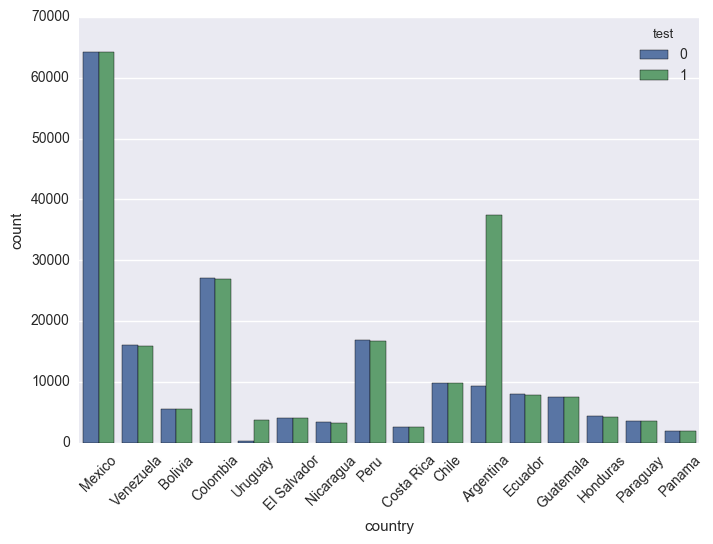

In [17]:
country_plot=sns.countplot(x='country',hue='test',data=df)
for label in country_plot.get_xticklabels():
    label.set_rotation(45)

## t-test with three offending countries removed

In [18]:
df[~df['country'].isin(['Argentina','Uruguay'])].groupby('test')['conversion'].count()

test
0    175540
1    174678
Name: conversion, dtype: int64

In [19]:
chisquare(df[~df['country'].isin(['Argentina','Uruguay'])].groupby('test')['conversion'].count())

Power_divergenceResult(statistic=2.1216613652068141, pvalue=0.14522893199086884)

In [20]:
df[~df['country'].isin(['Argentina','Uruguay'])].groupby('test')['conversion'].mean()

test
0    0.050148
1    0.050413
Name: conversion, dtype: float64

In [21]:
samp1 = df[(~df['country'].isin(['Argentina','Uruguay']))&(df['test']==1)].conversion
samp2 = df[(~df['country'].isin(['Argentina','Uruguay']))&(df['test']==0)].conversion

In [22]:
ttest_ind(samp1,samp2)

Ttest_indResult(statistic=0.35834777774948234, pvalue=0.72008328336515626)

## Tracking test and control group sizes over time

//anaconda/envs/my_projects_env/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


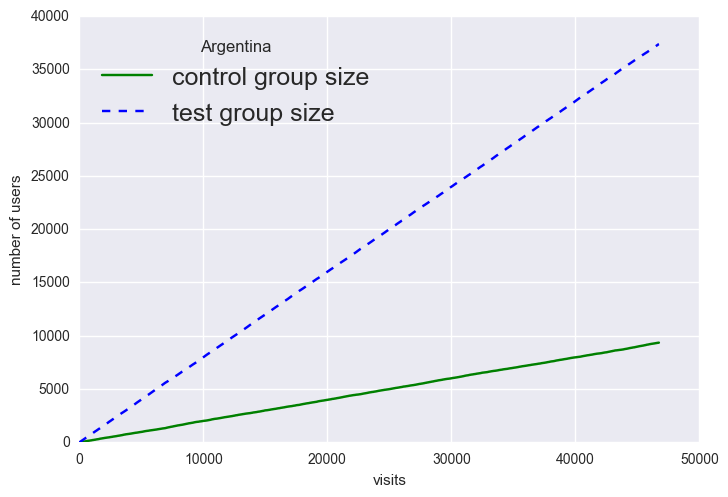

In [23]:
df_arg.loc[:,'date'] = pd.to_datetime(df_arg.loc[:,'date'])
df_arg = df_arg.sort_values('date')
df_arg['test_size']=df_arg['test'].cumsum()
df_arg['dummy']=1
df_arg['control_size'] = df_arg['dummy'].cumsum()-df_arg['test_size']
df_arg=df_arg.drop('dummy',1)
plt.plot(np.arange(len(df_arg)),df_arg['control_size'],'g-',label='control group size')
plt.plot(np.arange(len(df_arg)),df_arg['test_size'],'b-',label='test group size',linestyle='--')
plt.legend(loc=0,title='Argentina',fontsize=18)
plt.xlabel('visits')
plt.ylabel('number of users');

//anaconda/envs/my_projects_env/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


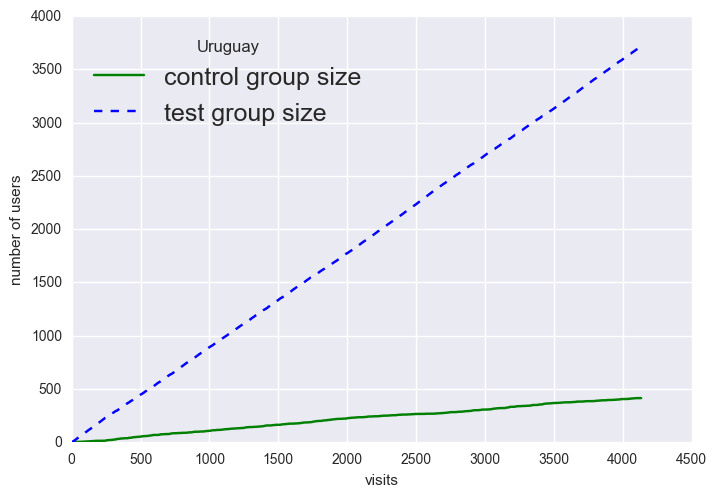

In [24]:
df_uru.loc[:,'date'] = pd.to_datetime(df_uru.loc[:,'date'])
df_uru = df_uru.sort_values('date')
df_uru['test_size']=df_uru['test'].cumsum()
df_uru['dummy']=1
df_uru['control_size'] = df_uru['dummy'].cumsum()-df_uru['test_size']
df_uru=df_uru.drop('dummy',1)

plt.plot(np.arange(len(df_uru)),df_uru['control_size'],'g-',label='control group size')
plt.plot(np.arange(len(df_uru)),df_uru['test_size'],'b-',label='test group size',linestyle='--')
plt.legend(loc=0,title='Uruguay',fontsize=18)
plt.xlabel('visits')
plt.ylabel('number of users');

//anaconda/envs/my_projects_env/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


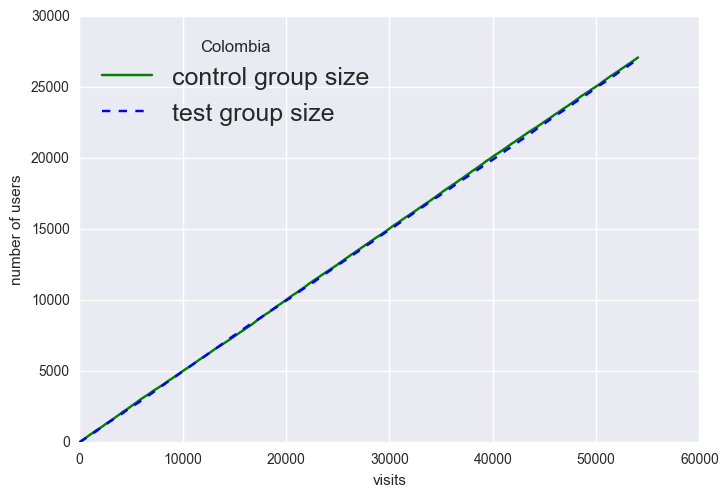

In [25]:
df_col = df[df['country']=='Colombia']
df_col.loc[:,'date'] = pd.to_datetime(df_col.loc[:,'date'])
df_col = df_col.sort_values('date')
df_col['test_size']=df_col['test'].cumsum()
df_col['dummy']=1
df_col['control_size'] = df_col['dummy'].cumsum()-df_col['test_size']
df_col=df_col.drop('dummy',1)

plt.plot(np.arange(len(df_col)),df_col['control_size'],'g-',label='control group size')
plt.plot(np.arange(len(df_col)),df_col['test_size'],'b-',label='test group size',linestyle='--')
plt.legend(loc=0,title='Colombia',fontsize=18)
plt.xlabel('visits')
plt.ylabel('number of users');

# t-tests for individual countries

In [26]:
header=['country','t','p-value']
print("{:>20} {:>20} {:>20}".format(*header))
print('           -------------------------------')
for country in df['country'].unique():
    samp1 = df[(df['country']==country)&(df['test']==1)].conversion
    samp2 = df[(df['country']==country)&(df['test']==0)].conversion
    t,p = ttest_ind(samp1,samp2,equal_var=False)
    row = [country,'{:.2g}'.format(t),'{:.2g}'.format(p)]
    print("{: >20} {: >20} {: >20}".format(*row))

             country                    t              p-value
           -------------------------------
              Mexico                  1.4                 0.17
           Venezuela                -0.56                 0.57
             Bolivia                -0.36                 0.72
            Colombia                 -0.8                 0.42
             Uruguay                 0.15                 0.88
         El Salvador                 -1.2                 0.25
           Nicaragua                 0.28                 0.78
                Peru                 0.29                 0.77
          Costa Rica                  0.4                 0.69
               Chile                    1                  0.3
           Argentina                -0.96                 0.34
             Ecuador               -0.048                 0.96
           Guatemala                -0.56                 0.57
            Honduras                -0.72                 0.47
            

## Check if any other distributions are significantly different between control and test groups

In [27]:
df_2 = df[~df['country'].isin(['Argentina','Uruguay'])]

In [28]:
df_2.groupby('country')['user_id'].count()

country
Bolivia         11124
Chile           19737
Colombia        54060
Costa Rica       5309
Ecuador         15895
El Salvador      8175
Guatemala       15125
Honduras         8568
Mexico         128484
Nicaragua        6723
Panama           3951
Paraguay         7347
Peru            33666
Venezuela       32054
Name: user_id, dtype: int64

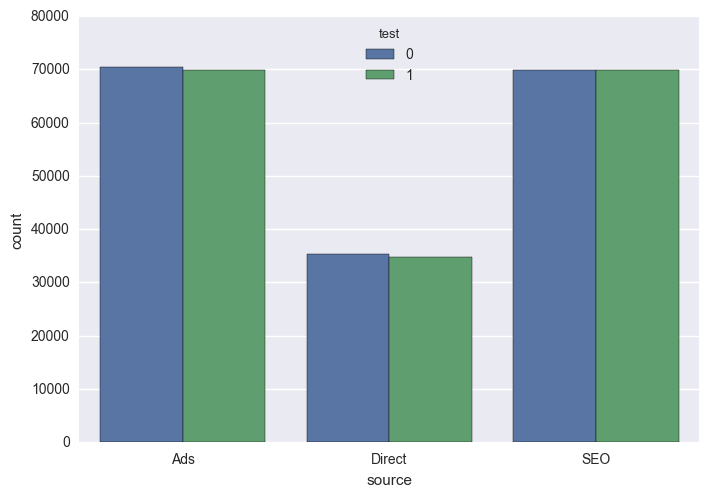

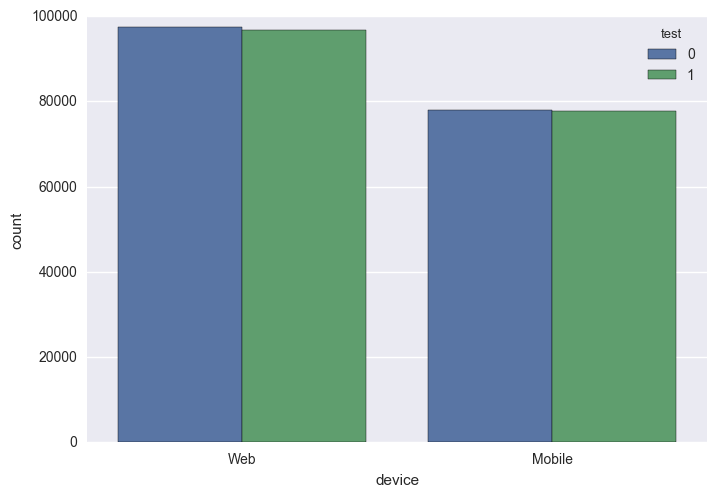

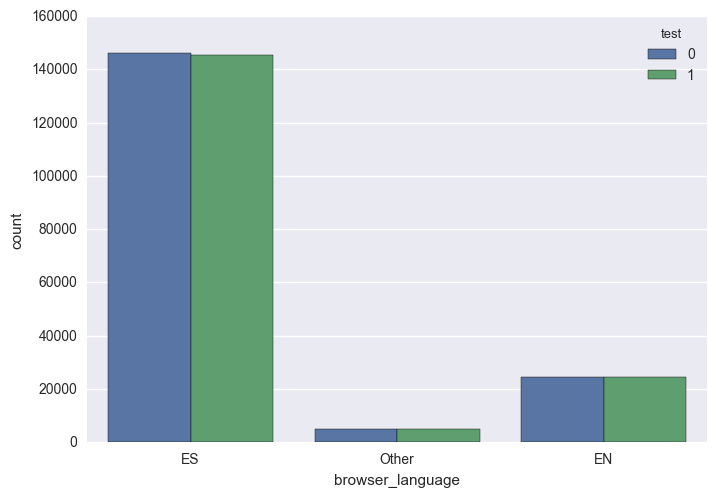

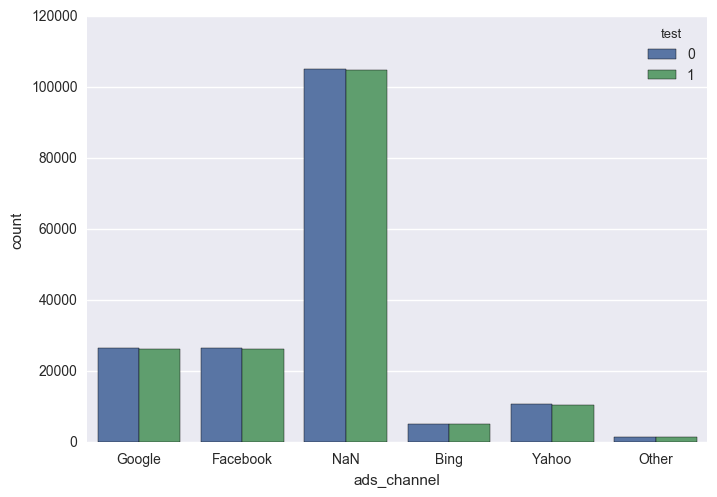

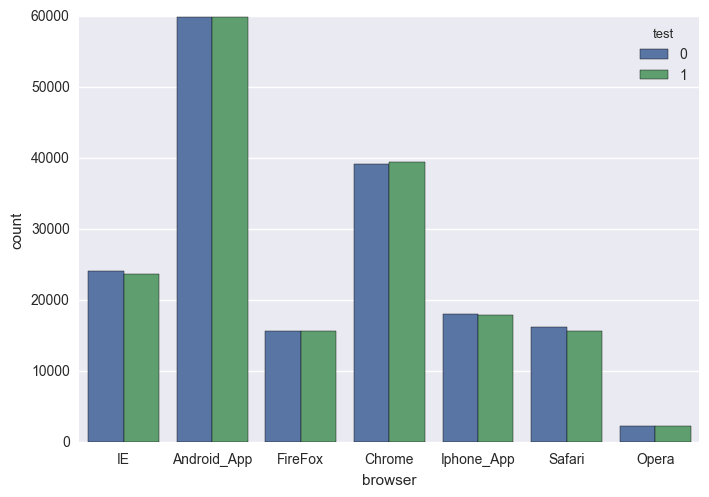

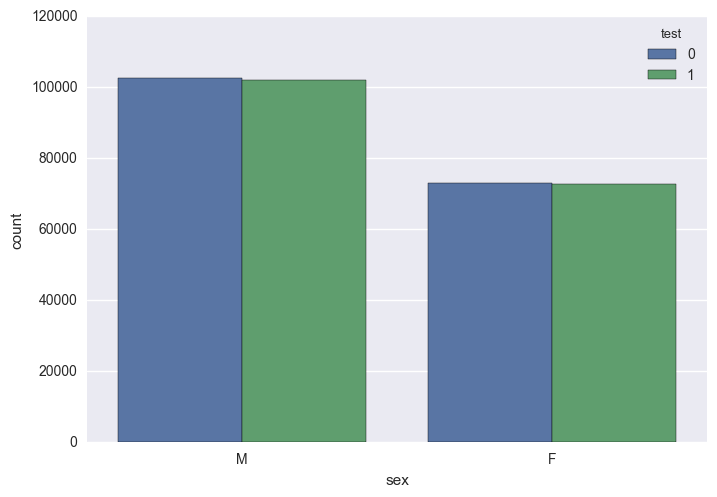

In [29]:
df_2=df_2.fillna('NaN')
cols=['source','device','browser_language','ads_channel','browser','sex']
for col in cols:
    plt.figure()
    plot = sns.countplot(x=col,hue='test',data=df_2)

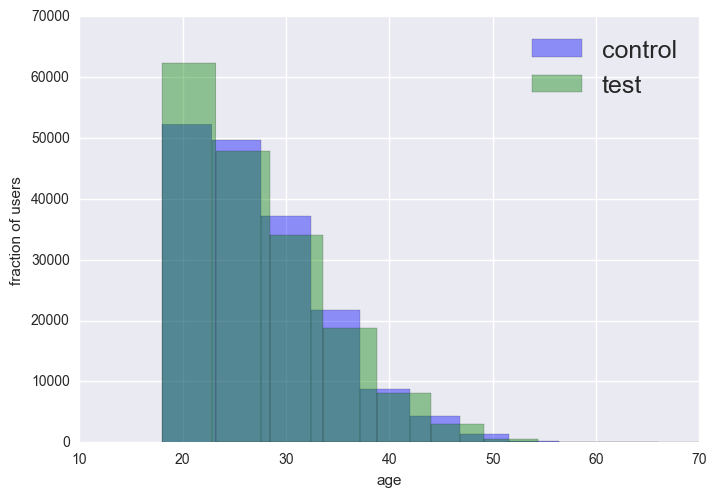

In [30]:
plt.hist(df_2[df_2['test']==0].age,alpha=0.4,label='control',color='b',bins=10)
plt.hist(df_2[df_2['test']==1].age,alpha=0.4,label='test',color='g',bins=10)
plt.legend(fontsize=18)
plt.xlabel('age')
plt.ylabel('fraction of users')

## 2-sample Anderson-Darling test tests the hypothesis that the two samples are drawn from the same distribution, without having to specify the distribution

In [31]:
from scipy.stats import anderson_ksamp
samp1 = df_2[df_2['test']==0].age.values
samp2 = df_2[df_2['test']==1].age.values

In [32]:
anderson_ksamp([samp1,samp2])

//anaconda/envs/my_projects_env/lib/python3.5/site-packages/scipy/stats/morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=0.028450222030758563, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.33798500285547406)

The critical values are for significance levels 25%, 10%, 5%, 2.5% and 1%

## Testing group sizes over time

In [33]:
df_arg.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country,test_size,control_size
31,730926,2015-11-30,Ads,Web,ES,Facebook,IE,0,0,F,26,Argentina,0,1
355706,608936,2015-11-30,SEO,Web,ES,NaN,IE,0,1,M,28,Argentina,1,1
124564,724849,2015-11-30,SEO,Web,ES,NaN,Opera,0,1,F,29,Argentina,2,1
355579,388651,2015-11-30,Ads,Web,ES,Yahoo,Chrome,0,1,F,26,Argentina,3,1
355435,15517,2015-11-30,Direct,Web,EN,NaN,Safari,0,1,F,21,Argentina,4,1


In [34]:
df.groupby('test')['conversion'].count()

test
0    185311
1    215774
Name: conversion, dtype: int64

In [35]:
df_arg['p_value'] = df_arg[['test_size','control_size']].apply(chisquare,axis=1).apply(pd.Series)[1]
df_col['p_value'] = df_col[['test_size','control_size']].apply(chisquare,axis=1).apply(pd.Series)[1]
df_uru['p_value'] = df_uru[['test_size','control_size']].apply(chisquare,axis=1).apply(pd.Series)[1]

(1e-05, 1)

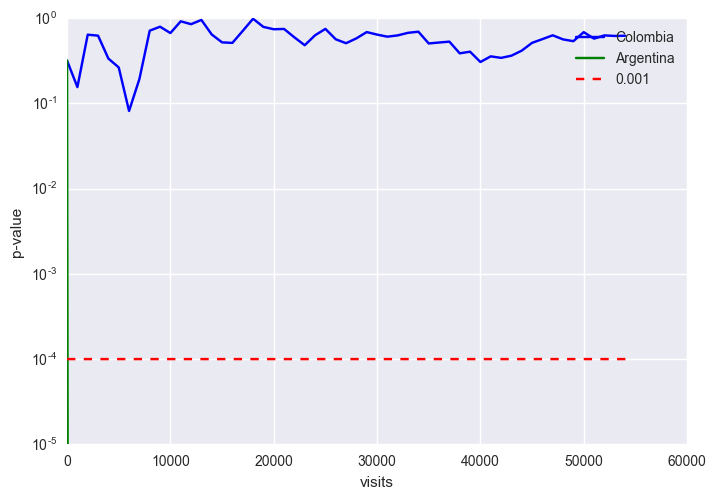

In [36]:
n = 1000
p = 0.0001
plt.plot(np.arange(len(df_col))[::n],df_col['p_value'][::n],'b-',label='Colombia')
#plt.plot(np.arange(len(df_uru))[::n],df_uru['p_value'][::n],'g-',label='Uruguay')
plt.plot(np.arange(len(df_arg))[::n],df_arg['p_value'][::n],'g-',label='Argentina')
plt.plot(np.arange(len(df_col)),[p]*len(df_col),'r-',label='0.001',linestyle='--')
plt.xlabel('visits')
plt.legend()

plt.ylabel('p-value')
plt.yscale('log')
plt.ylim((1e-5,1))

In [37]:
df['country'].unique()

array(['Mexico', 'Venezuela', 'Bolivia', 'Colombia', 'Uruguay',
       'El Salvador', 'Nicaragua', 'Peru', 'Costa Rica', 'Chile',
       'Argentina', 'Ecuador', 'Guatemala', 'Honduras', 'Paraguay',
       'Panama'], dtype=object)

In [38]:
df.loc[:,'date'] = pd.to_datetime(df.loc[:,'date'])
df = df.sort_values('date')
df['control'] = 1-df['test']
df['test_size']=df.groupby('country')['test'].cumsum()
df['control_size']=df.groupby('country')['control'].cumsum()

In [39]:
df['p_value']=df[['test_size','control_size']].apply(chisquare,axis=1).apply(pd.Series)[1]

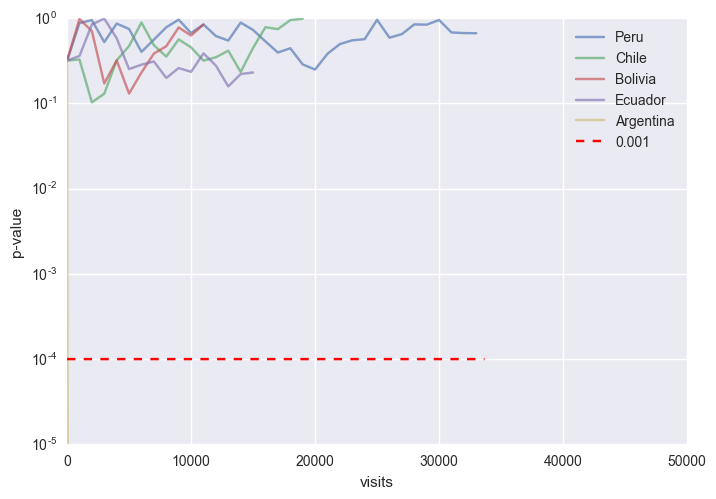

In [63]:
n = 1000
p = 0.0001
s = len(df[df['country']=='Peru'])
country_list = ['Peru','Chile','Bolivia','Ecuador','Argentina']
for country in country_list:
    x = df[df['country']==country]['test_size']+df[df['country']==country]['control_size']
    y = df[df['country']==country]['p_value'].values
    plt.plot(x[::n],y[::n],label=country,alpha=0.65)
plt.plot(np.arange(s),[p]*s,'r-',label='0.001',linestyle='--')
plt.legend()
plt.xlabel('visits')
plt.ylabel('p-value')
plt.yscale('log')
plt.ylim((1e-5,1));

In [61]:
df_2.groupby('test')['conversion'].count()

test
0    175540
1    174678
Name: conversion, dtype: int64